 # Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from collections import Counter
from itertools import product
import cv2
import math, random
from scipy.spatial import distance

np.random.seed(42) # For reproducibility

#%matplotlib qt
%matplotlib inline

# Defining Functions

In [2]:
def m_ij(m, i, j):
    rows, cols = m.shape
    m_i_j = 0
    for row in range(rows):
        for col in range(cols):
            m_i_j += np.power(row + 1, i) * np.power(col + 1, j) * m[row][col]
    return m_i_j

def centroid(m):
    m00 = m_ij(m, 0, 0)
    return [m_ij(m, 1, 0) / m00, m_ij(m, 0, 1) / m00]

def u_ij(m, i, j):
    rows, cols = m.shape
    m_i_j = 0
    x_, y_ = centroid(m)
    for row in range(rows):
        for col in range(cols):
            m_i_j += np.power(row + 1 - x_, i) * np.power(col + 1 - y_, j) * m[row][col]
    return m_i_j

def hu_Moments(m):
    u_00 = u_ij(m, 0, 0)
    
    eta = lambda m, i, j : u_ij(m, i, j) / np.power(u_00, (i + j) / 2 + 1)
    
    eta_20 = eta(m, 2, 0)
    eta_02 = eta(m, 0, 2)
    eta_11 = eta(m, 1, 1)
    eta_30 = eta(m, 3, 0)
    eta_12 = eta(m, 1, 2)
    eta_21 = eta(m, 2, 1)
    eta_03 = eta(m, 0, 3)
    
    phi_1 = eta_20 + eta_02
    phi_2 = np.power(eta_20 - eta_02, 2) + 4 * np.power(eta_11, 2)
    phi_3 = np.power(eta_30 - 3 * eta_12, 2) + np.power(3 * eta_21 - eta_03, 2)
    phi_4 = np.power(eta_30 + eta_12, 2) + np.power(eta_21 + eta_03, 2)
    phi_5 = (eta_30 - 3 * eta_12) * (eta_30 + eta_12) * (np.power(eta_30 + eta_12, 2) - 3 * np.power(eta_21 + eta_03, 2)) + (3 * eta_21 - eta_03) * (eta_21 + eta_03) * (3 * np.power(eta_30 + eta_12, 2) - np.power(eta_21 - eta_03, 2))
    phi_6 = (eta_20 - eta_02) * (np.power(eta_30 + eta_12, 2) - np.power(eta_21 + eta_03, 2)) + 4 * eta_11 * (eta_30 + eta_12) * (eta_21 + eta_03)
    phi_7 = (3 * eta_21 - eta_03) * (eta_30 + eta_12) * (np.power(eta_30 - eta_12, 2) - 3 * np.power(eta_21 - eta_03, 2)) + (3 * eta_12 - eta_30) * (eta_21 + eta_03) * (3 * np.power(eta_30 - eta_12, 2) - np.power(eta_21 - eta_03, 2))
    
    return np.array([phi_1, phi_2, phi_3, phi_4, phi_5, phi_6, phi_7])

def twoPassLabel(image):
    rows, cols = image.shape
    nm = np.zeros_like(image)
    label = 0
    equivalent = []

    # First pass
    for r in range(rows):
        for c in range(cols):
            if(image[r][c] == 0):
                nm[r][c] = 0
            else:
                if (nm[r - 1][c] == 0 and nm[r][c - 1] == 0):
                    label -= -1
                    nm[r][c] = label
                elif (nm[r - 1][c] != 0 and nm[r][c - 1] == 0):
                    nm[r][c] = nm[r - 1][c]
                elif (nm[r][c - 1] != 0 and nm[r - 1][c] == 0):
                    nm[r][c] = nm[r][c - 1]
                elif (nm[r][c - 1] != 0 and nm[r][c - 1] != 0):
                    nm[r][c] = nm[r][c - 1]
                    if(nm[r - 1][c] and nm[r][c - 1] != nm[r - 1][c]):
                        #print(f'{nm[r][c - 1]} is equivalent to {nm[r - 1][c]}')
                        equivalent.append([nm[r][c - 1], nm[r - 1][c]])
                        
    # Second pass
    for e in equivalent:
        for row in range(rows):
            for col in range(cols):
                if(nm[row][col] == e[0]):
                    nm[row][col] = e[1]
                    
    number_of_objects = len(Counter(nm.flatten())) - 1
    
    # Settings the labels from 1 to number_of_objects
    new_label = 1
    for i in range(1, label + 1):
        mask = np.argwhere(nm == i)
        if (not len(mask)):
            continue
        #print(f'{i} is in {mask} and size {len(mask)}')
        for pair in mask:
            nm[pair[0]][pair[1]] = new_label
        new_label -= -np.power(1, 0)
    
    return number_of_objects, nm

def min_distance(test_patterns, training_set, Y_train):
    #distances = []
    DistanceMatrix = distance.cdist(test_patterns, training_set, 'euclidean')
    positions = np.argmin(DistanceMatrix, axis = 1)
    classes = [Y_train[p] for p in positions]
    
    return np.array(classes)+1

def KNN(test_patterns, training_set, Y_train, k = 1):
    
    indexed_and_sorted_distances = []
    classes = []
    
    distances = distance.cdist(test, X_train_hu, 'euclidean')
    
    for i, distancia in enumerate(distances):    
        indexed_and_sorted_distances.append(sorted(np.array(list(zip(Y_train, distancia))), key = lambda l : l[1]))
        
    indexed_and_sorted_distances = np.array(indexed_and_sorted_distances)

    for i in range(len(distances)):
        classes.append(Counter(indexed_and_sorted_distances[:,:40][i].T[0]).most_common(1)[0][0])
        
    return np.array(classes)+1

# Loading Images

In [3]:
main_path = 'C:/Users/jeff_/Dropbox/Jupyter Notebooks/dataset/'
extension = '/*.png'
train = 'entrenamiento/s'
test = 'prueba/'
Y_train = []
Y_test = []
images_array = []

num_classes = 6

for i in range(num_classes):
    filelist = glob(''.join([main_path, train, str(i + 1), extension]))
    images_array += [np.array(cv2.imread(fname, cv2.IMREAD_GRAYSCALE)) for fname in filelist]
    for num in range(len(filelist)):
        Y_train.append(i)

X_train = np.array(images_array)

images_array.clear()

# Loading test set

filelist = glob(''.join([main_path, test, extension]))
images_array += [np.array(cv2.imread(fname, cv2.IMREAD_GRAYSCALE)) for fname in filelist]
#for num in range(len(filelist)):
#    Y_test.append(i)

X_test = np.array(images_array)

#Y_train = np.array(Y_train)
#Y_test = np.array(Y_test)

## Showing an instance per class

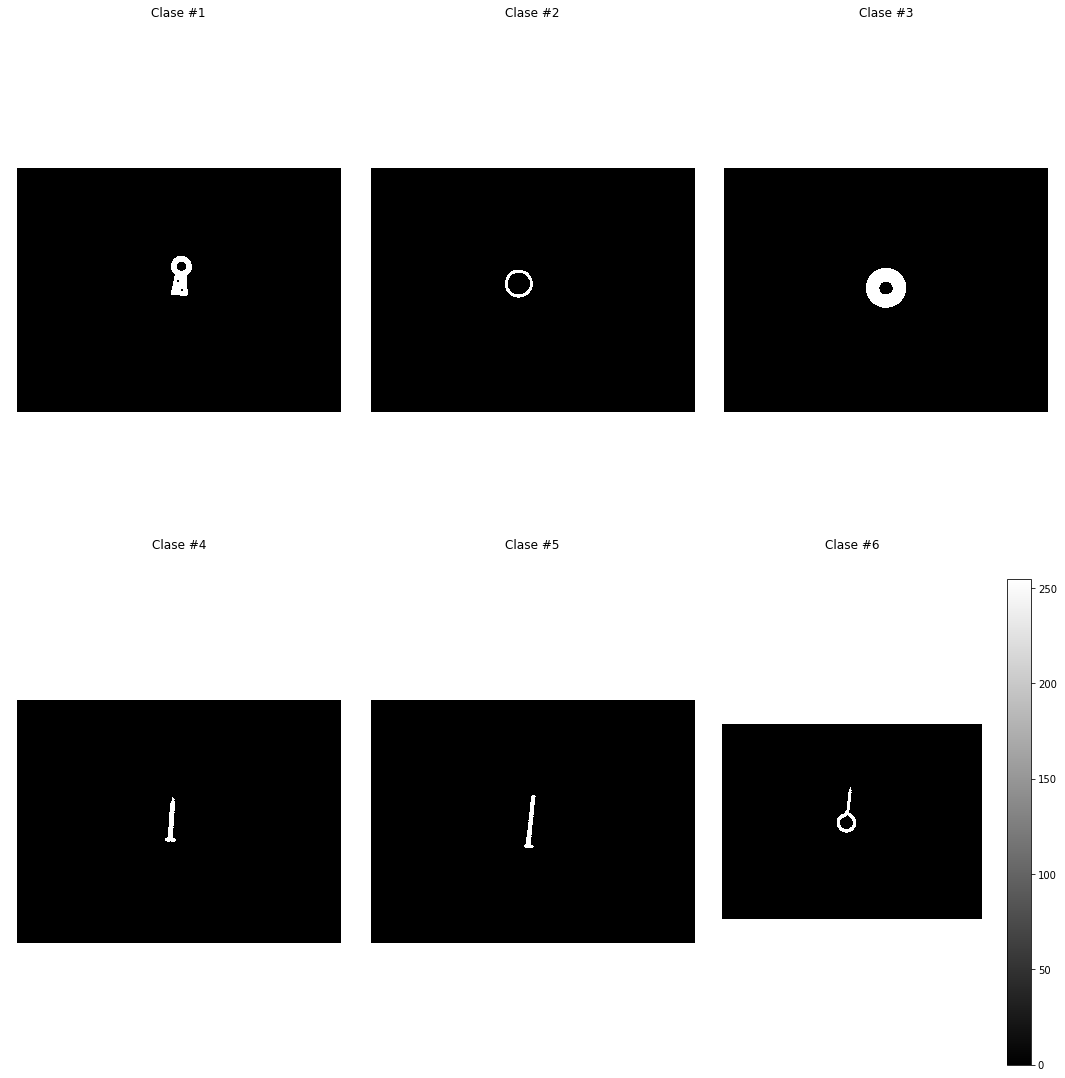

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(15,15))
count = 0

for i in range(2):
    for j in range(3):
        ax = axs[i][j]
        
        c = ax.pcolor(X_train[count*20], cmap = 'gray')
        #c = ax.imshow(X_train[count*20], cmap = 'inferno', interpolation='nearest')
        ax.axis('off')
        ax.axis('equal')
        ax.set_title(f'Clase #{count + 1}').set_position([0.5, 1.05])
        count += 1
fig.colorbar(c)
fig.tight_layout()
plt.show()

In [5]:
print(f'Training set. Instances per class: {Counter(Y_train)}')

Training set. Instances per class: Counter({0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20})


In [6]:
# Normalizing the data

X_train = np.around(X_train / 255)

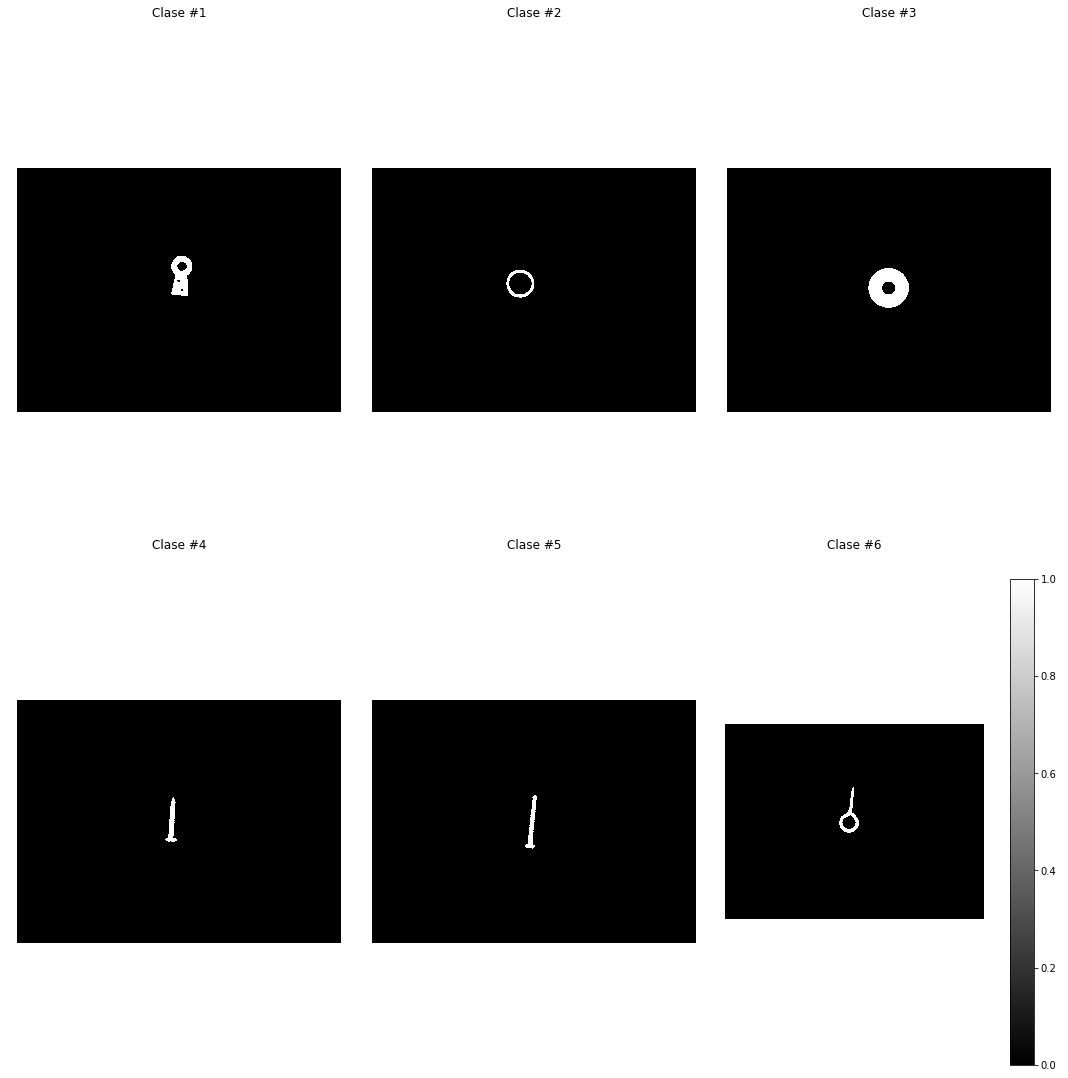

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(15,15))
count = 0

for i in range(2):
    for j in range(3):
        ax = axs[i][j]
        
        c = ax.pcolor(X_train[count*20], cmap = 'gray')
        #c = ax.imshow(X_train[count*20], cmap = 'inferno', interpolation='nearest')
        ax.axis('off')
        ax.axis('equal')
        ax.set_title(f'Clase #{count + 1}').set_position([0.5, 1.05])
        count += 1
fig.colorbar(c)
fig.tight_layout()
plt.show()

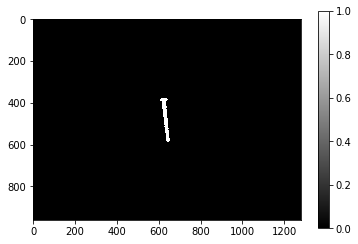

In [8]:
# Instance number 80 in the training set
c = plt.imshow(X_train[80].reshape(960, 1280), cmap = 'gray')
plt.colorbar(c)

In [9]:
epsilon = 3 # To avoid the zero in the log
# We take the logarithm to escale the Hu moments

X_train_hu = []

for x in X_train:
    X_train_hu.append(cv2.HuMoments(cv2.moments(x)).reshape(1, -1)[0]) # Hu Moments using cv2 implementation
    #X_train_hu.append(hu_Moments(x)) # Hu Moments using own implementatios

X_train_hu = np.array(X_train_hu)

In [10]:
X_train_hu[80]

array([1.00071999e+00, 9.64437319e-01, 1.95332512e-02, 1.48544645e-02,
       2.52964079e-04, 1.45175302e-02, 5.79459095e-06])

# Preprocessing for Classification

In [11]:
# Selection of a test image
a = 15
image = X_test[a]

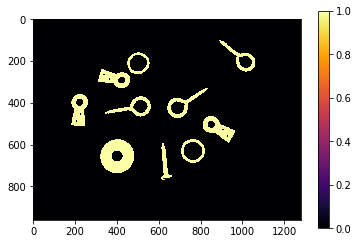

In [12]:
# Showing the image
c = plt.imshow(X_test[a] / 255, cmap = 'inferno')
plt.colorbar(c)

In [13]:
# Labeling the binary image to classify
rest, labels = cv2.connectedComponents(image) # Using the cv2 implementation
#rest, labels = twoPassLabel(image) #Using own implementation

In [14]:
print(labels.shape)
rows = labels.shape[0]
cols = labels.shape[1]

(960, 1280)


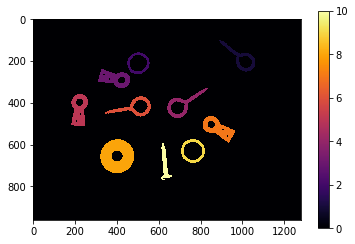

In [15]:
c = plt.imshow(labels, cmap = 'inferno')
plt.colorbar(c)

In [16]:
# Creating an array of the shape (number of objest, rows of image, columns of image)

segments = np.zeros((rest-1, rows, cols))

for i in range(0, rest - 1):
    segments[i] = np.array(list(map(lambda x : 1 if i < x < i + 2 else 0, labels.flatten()))).reshape(labels.shape)

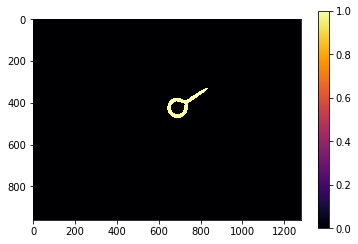

In [17]:
# Extraction of an object
c = plt.imshow(segments[3].reshape(960, 1280), cmap = 'inferno')
plt.colorbar(c)

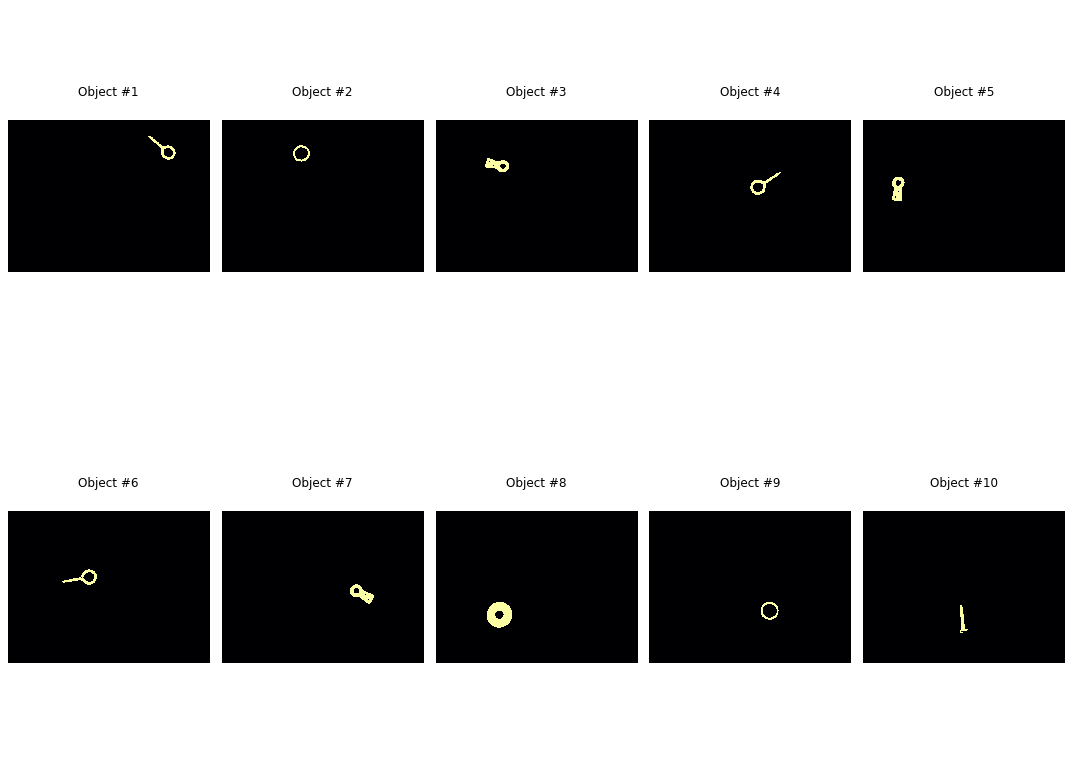

In [18]:
# Showing all the labeled objects

fig, axs = plt.subplots(2, (rest - 1) // 2, figsize=(15,11))
count = 0

for i in range(2):
    for j in range((rest - 1) // 2):
        ax = axs[i][j]
        
        #c = ax.pcolor(thetas[i + j][1:].reshape(28, 28), cmap = 'gray')
        ax.imshow(np.array(segments[count]), cmap = 'inferno', interpolation='nearest')
        ax.axis('off')
        ax.axis('equal')
        ax.set_title(f'Object #{count + 1}').set_position([0.5, 0.75])
        count += 1
        
fig.tight_layout()
plt.show()

In [19]:
# Getting the Hu moments for all the objects in the test image

test = np.array(list(map(lambda imagen : cv2.HuMoments(cv2.moments(imagen)).reshape(1,-1)[0], segments)))

## Minimum Euclidean Distance

In [20]:
classifications = min_distance(test, X_train_hu, Y_train)

In [21]:
classifications

array([6, 2, 1, 6, 1, 6, 1, 3, 2, 4])

In [22]:
tagged = np.sum([segments[i] * classifications[i] for i in range(len(classifications))], axis = 0)

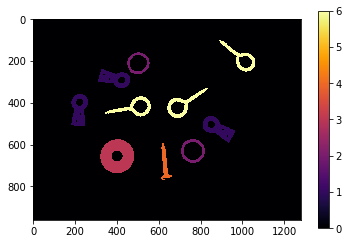

In [23]:
c = plt.imshow(tagged, cmap = 'inferno')
plt.colorbar(c)

## K - Nearest Neighbours

In [24]:
classifications = KNN(test, X_train_hu, Y_train, k = 5)

In [25]:
classifications.shape

(10,)

In [26]:
tagged = np.sum([segments[i] * classifications[i] for i in range(len(classifications))], axis = 0)

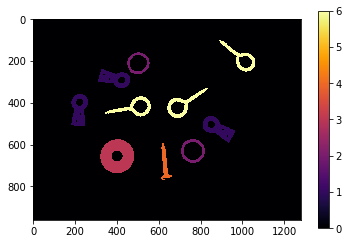

In [27]:
c = plt.imshow(tagged, cmap = 'inferno')
plt.colorbar(c)